# Stock Direction — Phase 8 Report

This notebook compiles the key results from Phase 6 (diagnostics) and Phase 7 (backtest) into a concise report.


In [20]:
# --- Imports & artifact paths ---
import json
from pathlib import Path
import pandas as pd
from IPython.display import Image, display, Markdown

DATA = Path("data")
ART  = Path("artifacts")
FIG  = Path("reports/figures")

assert (DATA/"multiticker_tau_sweep.csv").exists(), "Run Phase 7 to create data/multiticker_tau_sweep.csv"
assert (ART/"backtest_summary.json").exists(), "Run Phase 7 to create artifacts/backtest_summary.json"

sweep   = pd.read_csv(DATA/"multiticker_tau_sweep.csv")
summary = json.load(open(ART/"backtest_summary.json", "r"))
tau     = json.load(open(ART/"threshold.json", "r"))["LR"]["tau"] if (ART/"threshold.json").exists() else None

display(Markdown(f"**Loaded:** sweep={len(sweep)} rows · backtest_summary.json ✓ · best τ = **{tau}**"
                 if tau is not None else
                 f"**Loaded:** sweep={len(sweep)} rows · backtest_summary.json ✓ · best τ not found"))


**Loaded:** sweep=16 rows · backtest_summary.json ✓ · best τ = **0.54**

In [21]:
# --- Best-row snapshot (per model) ---
best = (sweep.sort_values(["model","Sharpe"], ascending=[True, False])
              .groupby("model").head(1).reset_index(drop=True))

fmt = {"tau":"{:.2f}","Sharpe":"{:.2f}","CAGR":"{:.2%}",
       "total_return":"{:.2%}","max_drawdown":"{:.1%}",
       "hit_rate":"{:.2f}","vol_annual":"{:.2f}"}

best_display = best[["model","tau","Sharpe","CAGR","total_return","max_drawdown","hit_rate","vol_annual"]].copy()
display(best_display.style.format(fmt))


,model,tau,Sharpe,CAGR,total_return,max_drawdown,hit_rate,vol_annual
0,LR,0.54,0.43,6.17%,11.04%,-16.1%,0.29,0.19


In [22]:
# --- KPI cards (LR) ---
lr = summary["models"].get("LR", {})
cards = pd.DataFrame([{
    "Model": "LR",
    "τ (threshold)": lr.get("tau", None),
    "Sharpe": lr.get("Sharpe", None),
    "CAGR": lr.get("CAGR", None),
    "Total Return": lr.get("total_return", None),
    "Max Drawdown": lr.get("max_drawdown", None),
    "Hit Rate": lr.get("hit_rate", None),
    "Vol (Annual)": lr.get("vol_annual", None),
}])
display(cards.style.format({
    "τ (threshold)":"{:.2f}","Sharpe":"{:.2f}",
    "CAGR":"{:.2%}","Total Return":"{:.2%}",
    "Max Drawdown":"{:.1%}","Hit Rate":"{:.2f}",
    "Vol (Annual)":"{:.2f}"
}))


,Model,τ (threshold),Sharpe,CAGR,Total Return,Max Drawdown,Hit Rate,Vol (Annual)
0,LR,0.54,0.43,6.17%,11.04%,-16.1%,0.29,0.19


### equity_curve_lr.png

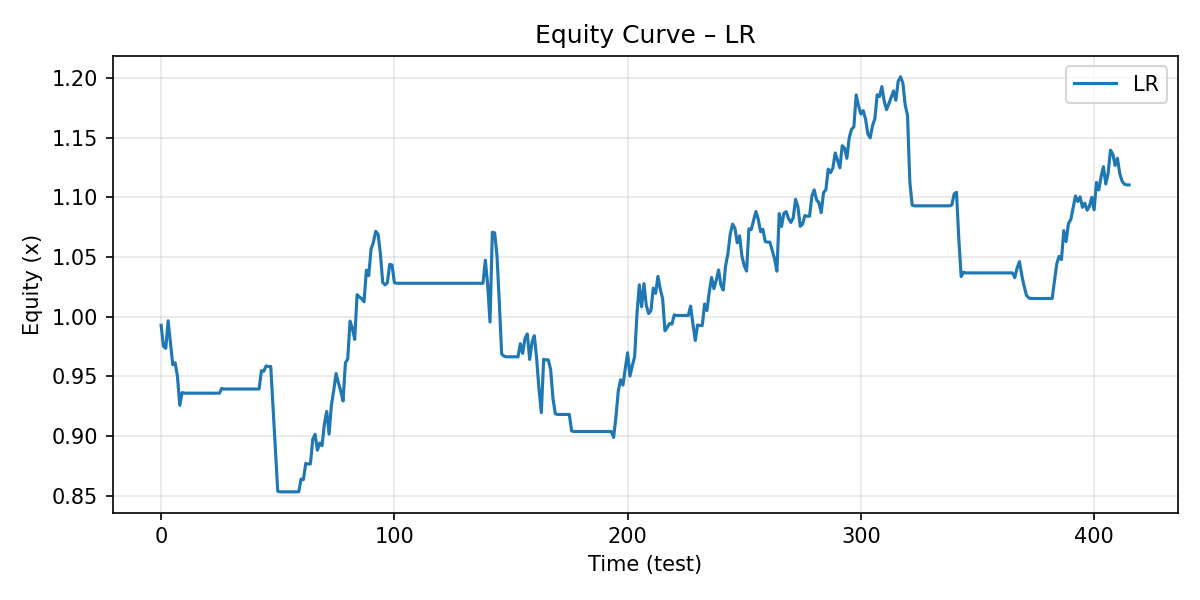

### equity_curve_vs_buyhold.png

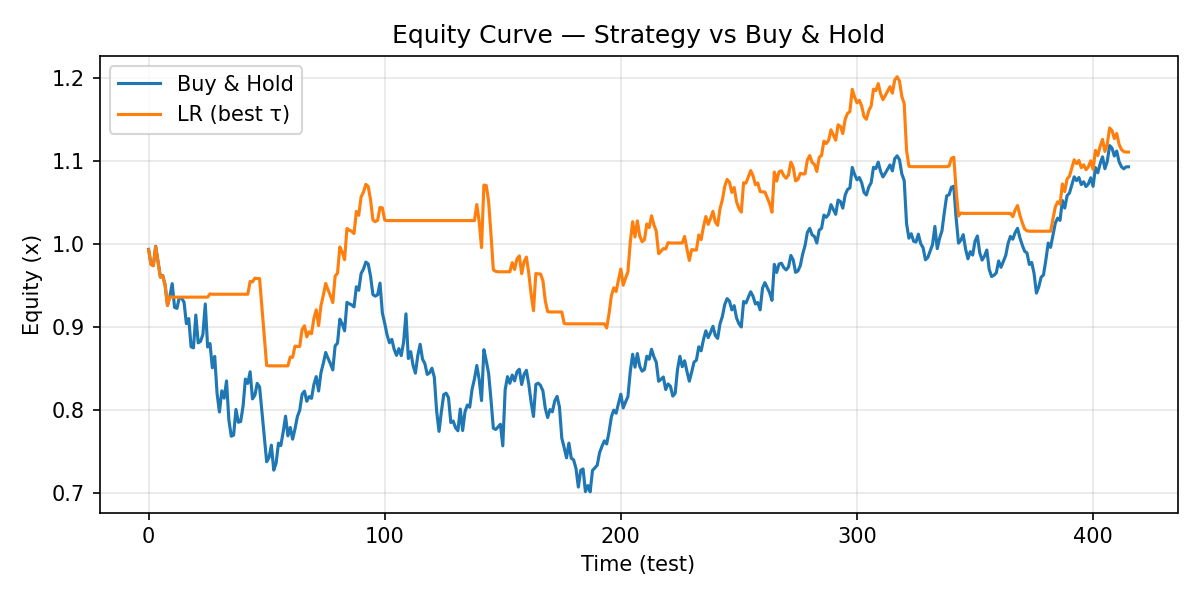

In [23]:
# --- Equity curves (from Phase 7) ---
for fn in ["equity_curve_lr.png", "equity_curve_vs_buyhold.png"]:
    p = (FIG / fn)
    if p.exists():
        display(Markdown(f"### {fn}"))
        display(Image(filename=str(p)))
    else:
        display(Markdown(f"**Missing:** {p}"))


### reliability_lr_nb05.png

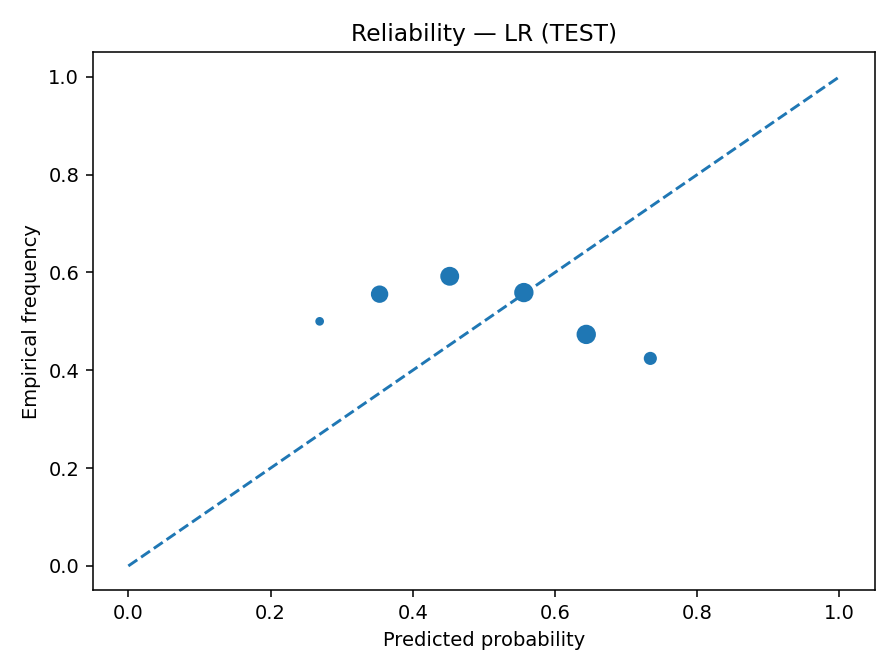

### lr_feature_importance_topk.png

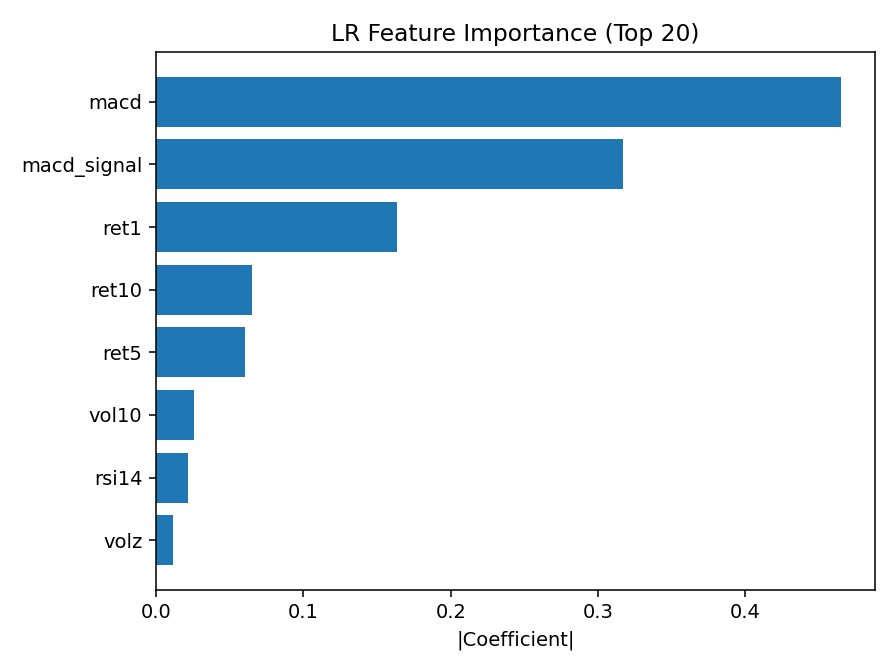

### roc_LR_test.png

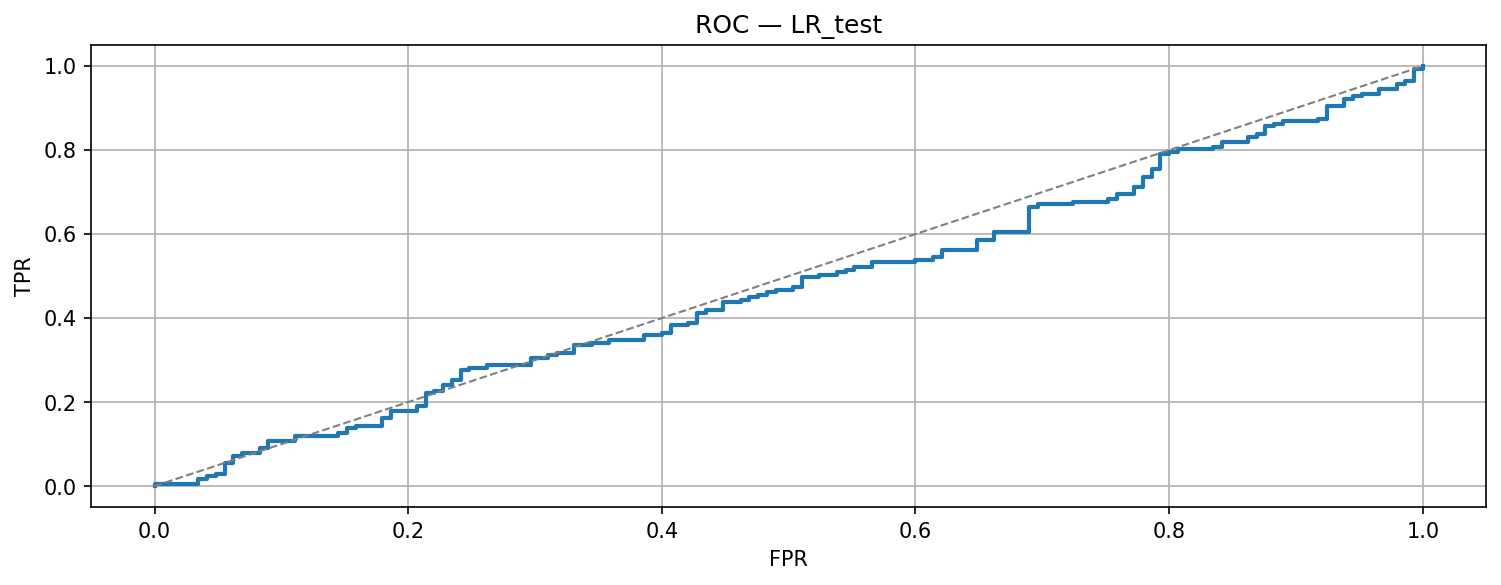

### pr_LR_test.png

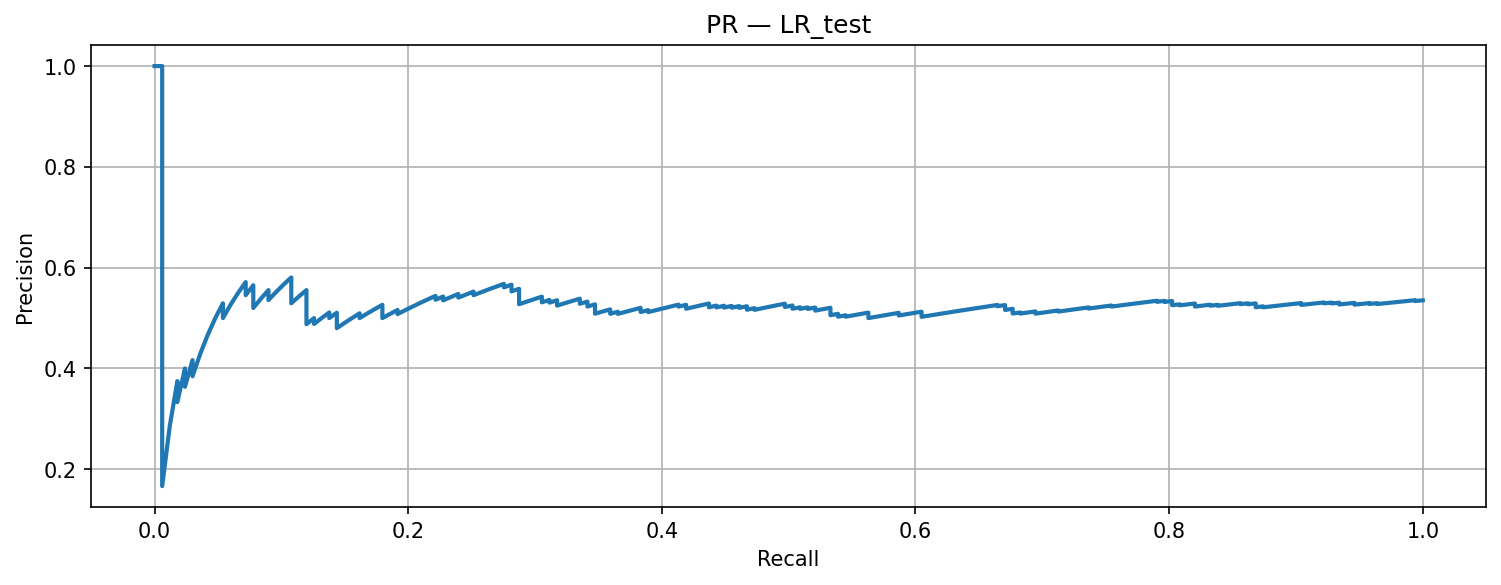

In [24]:
# --- Phase-6 diagnostics (auto-discover) ---
candidates = [
    "calibration_logreg.png", "reliability_lr_nb05.png",
    "logreg_coef_importance.png", "lr_feature_importance_top*.png",
    "shap_importance.png", "roc_LR_test.png", "pr_LR_test.png"
]
found = []
for pat in candidates:
    for p in FIG.glob(pat):
        if p not in found:
            display(Markdown(f"### {p.name}"))
            display(Image(filename=str(p)))
            found.append(p)

if not found:
    display(Markdown("_No Phase-6 figures found in reports/figures_."))


## Assumptions & Caveats

- **Target:** Next-day direction (binary), ticker = AAPL (confirm).
- **Costs:** FEE_BPS = 5, SLIPPAGE_BPS = 0.
- **Strategy:** Long/flat using probability threshold τ (selected via Sharpe).
- **Selected:** LR with τ ≈ best from the sweep.
- **Risks:** Regime shifts; turnover/capacity; slippage model realism; data revisions; look-ahead leakage mitigated by time splits.
- **Next steps:** Walk-forward re-fit, τ×fee robustness, confidence sizing, multi-ticker ensemble.


In [25]:
# --- Manifest of key files used/shown ---
manifest = {
    "sweep_csv": str(DATA/"multiticker_tau_sweep.csv"),
    "summary_json": str(ART/"backtest_summary.json"),
    "threshold_json": str(ART/"threshold.json") if (ART/"threshold.json").exists() else None,
    "figures_present": sorted([p.name for p in FIG.glob("*.png")]),
}
manifest


{'sweep_csv': 'data\\multiticker_tau_sweep.csv',
 'summary_json': 'artifacts\\backtest_summary.json',
 'threshold_json': 'artifacts\\threshold.json',
 'figures_present': ['equity_curve_lr.png',
  'equity_curve_vs_buyhold.png',
  'lr_feature_importance_topk.png',
  'pr_LR_test.png',
  'pr_XGB_test.png',
  'pr_nb02.png',
  'pr_nb05.png',
  'reliability_lr_nb05.png',
  'roc_LR_test.png',
  'roc_XGB_test.png',
  'roc_nb02.png',
  'roc_nb05.png']}

In [26]:
!jupyter nbconvert --to html "08_report.ipynb" --output "StockDirectionReport.html" --output-dir "../reports"


[NbConvertApp] Converting notebook 08_report.ipynb to html
[NbConvertApp] Writing 291217 bytes to ..\reports\StockDirectionReport.html
